# Create overview figures
This notebook creates daily overview figures and also shows how to work with the level2 data

## Setup

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import sys
# Path to pycloud folder (https://github.com/raspstephan/sugar-flower-fish-or-gravel/tree/master/pyclouds)
sys.path.append("/Users/haukeschulz/Documents/PhD/Work/Own/AI_CloudClassification/CloudClassificationDay/cloud-classification/")

sys.path.append("../helpers/")

In [15]:
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')
import os
import tqdm
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import Normalize
import dask.array as da
import xarray as xr
import zarr
from pyclouds import *
from helpers import *

In [4]:
# Level1 filename
level1_file = '../processed_data/EUREC4A_ManualClassifications_l1.nc'

# Level2 filename
level2_file = '../processed_data/EUREC4A_ManualClassifications_MergedClassifications.zarr'

savefig = False # True: loop through all images and save heatmap, otherwise show first day inline

In [5]:
# pattern_dic_inv = {0: 'Sugar', 1: 'Flower', 2: 'Fish', 3: 'Gravel'}

## Prepare data

In [6]:
# Load level 1 data
ds_l1 = xr.open_dataset(level1_file)
df_l1 = ds_l1.to_dataframe()

In [7]:
# Load level 2 data
if os.path.exists(level2_file):
    # Open file for reading
    ds_l2 = xr.open_zarr(level2_file)
elif os.path.exists(level2_file+'.zip'):
    print('Please unzip {} first an rerun.'.format(level2_file+'.zip'))
    sys.exit()
else:
    print('Run create_level2.py to create the level2 data')

In [8]:
da_arr = ds_l2.mask

In [9]:
# # Connect level1 data and level2 data (level2 only contains masks and no additional information)
# classification_id_idx_dict = {}
# for c, (clas_id, df) in enumerate(df_l1.groupby('classification_id')):
#     classification_id_idx_dict[clas_id] = c

## Start plotting

### Daily classification frequency based on the workflow EUREC4A (VIS)
Heatmap of all classifications based on MODIS visible images only (GOES16 is ignored here)

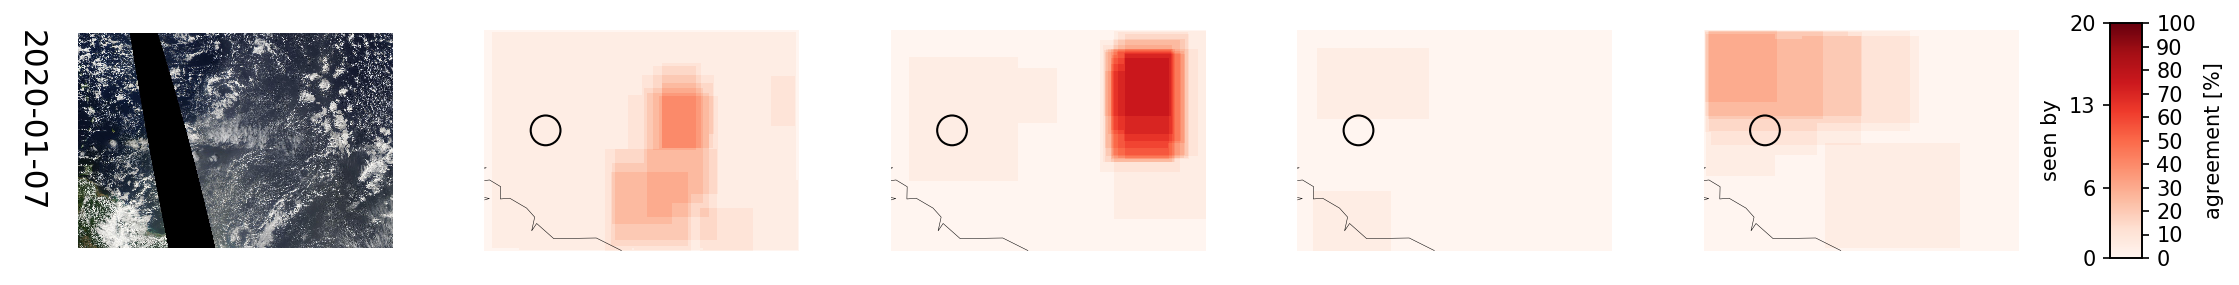

In [16]:
path_to_MODISVIS = '../source_images/EUREC4A_VIS_workflow/EUREC4A_MODIS_AQUA-VIS/'
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (VIS)'
instrument = 'MODIS'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_arr = np.zeros((len(np.unique(date_df.user_name)),
                         da_arr.shape[1],
                         da_arr.shape[2],
                         da_arr.shape[3]
                        ), dtype=bool)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_name, user_df) in enumerate(date_df_sel.groupby('user_name')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr = da_arr.sel({'classification_id':class_ids}).sum(axis=0).compute()
        user_arr = np.where(user_arr>0, True, False)
        date_arr[u, :,:,:] = user_arr
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames)
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
#         x, y = m(lon_grid, lat_grid)
        cs = m.imshow(np.sum(date_arr[:,:,:,p-1], axis=0).T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = plt.imread(path_to_MODISVIS+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, len(np.unique(date_df_sel.user_name)),4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

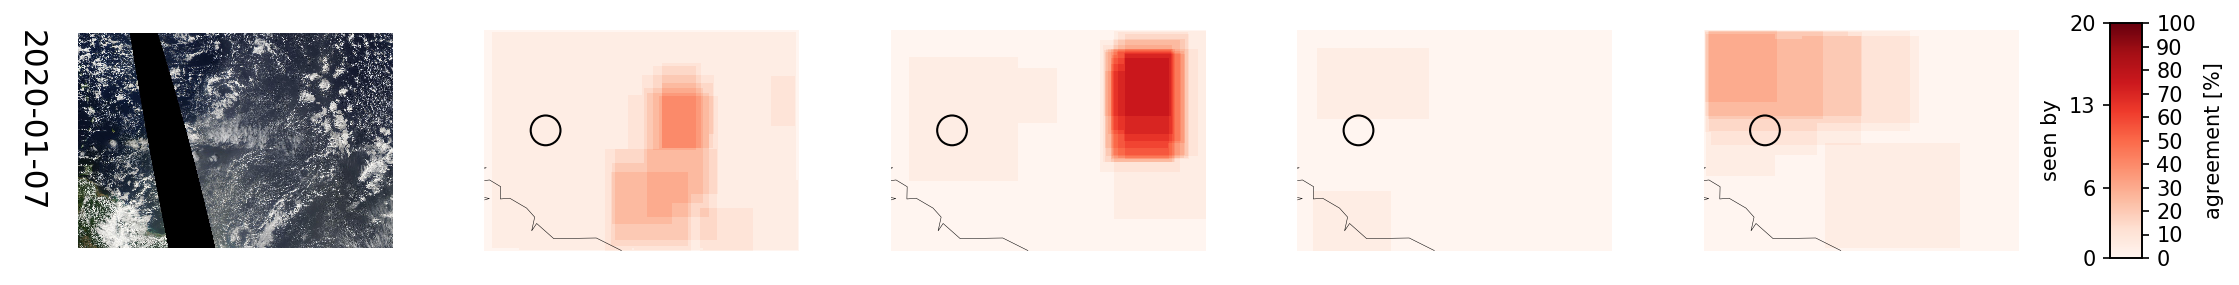

In [17]:
path_to_MODISVIS = '../source_images/EUREC4A_VIS_workflow/EUREC4A_MODIS_AQUA-VIS/'
lons = np.linspace(-62,-40,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (VIS)'
instrument = 'MODIS'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
#     if date != dt.datetime(2020,2,7).date(): continue
    
    date_arr = np.zeros((len(np.unique(date_df.user_name)),
                         da_arr.shape[1],
                         da_arr.shape[2],
                         da_arr.shape[3]
                        ), dtype=bool)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_name, user_df) in enumerate(date_df_sel.groupby('user_name')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr = da_arr.sel({'classification_id':class_ids}).sum(axis=0).compute()
        user_arr = np.where(user_arr>0, True, False)
        date_arr[u, :,:,:] = user_arr
        
    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames)
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
#         x, y = m(lon_grid, lat_grid)
        cs = m.imshow(np.sum(date_arr[:,:,:,p-1], axis=0).T,
                      origin='upper', cmap='Reds', norm=norm,
                      extent=[-62,-40,5,20])
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show AQUA image:
    img = plt.imread(path_to_MODISVIS+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, len(np.unique(date_df_sel.user_name)),4)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/VIS_dailyaverage/EUREC4A_ManualClassifications_MODISAverage_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

### Daily classification frequency based on ICON albedo simulation data

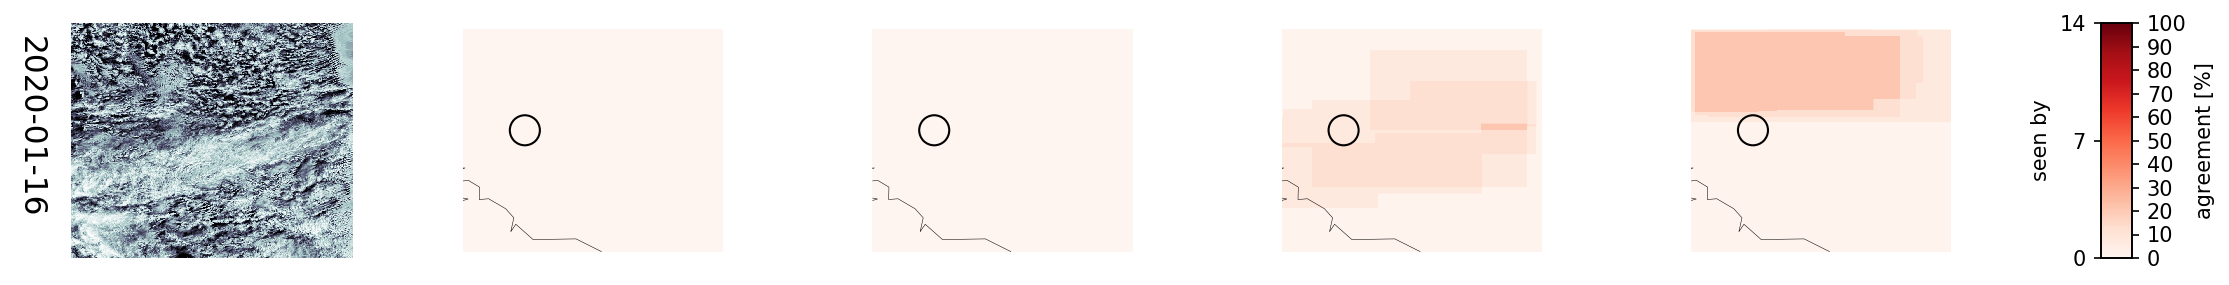

In [18]:
path_to_ICON = '../source_images/EUREC4A_ICON_alb_workflow/'
lons = np.linspace(-62,-44,882)
lats = np.linspace(20,5,735)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (ICON; albedo)'
instrument = 'n/a'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_arr = np.zeros((len(np.unique(date_df.user_name)),
                         da_arr.shape[1],
                         da_arr.shape[2],
                         da_arr.shape[3]
                        ), dtype=bool)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_name, user_df) in enumerate(date_df_sel.groupby('user_name')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr = da_arr.sel({'classification_id':class_ids}).sum(axis=0).compute()
        user_arr = np.where(user_arr>0, True, False)
        date_arr[u, :,:,:] = user_arr

    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, 'ICON_albedo')
    if filename is None: continue
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)


    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
        x, y = m(lon_grid, lat_grid)
        cs = m.contourf(x,y,np.sum(date_arr[:,:882,:735,p-1], axis=0), cmap='Reds', norm=norm)
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show animation image:
    img = plt.imread(path_to_ICON+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, len(np.unique(date_df_sel.user_name)),3)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/ICON_alb_dailyaverage/EUREC4A_ManualClassifications_ICONDailyAverage_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

### Daily classification frequency based on the workflow EUREC4A (IR)

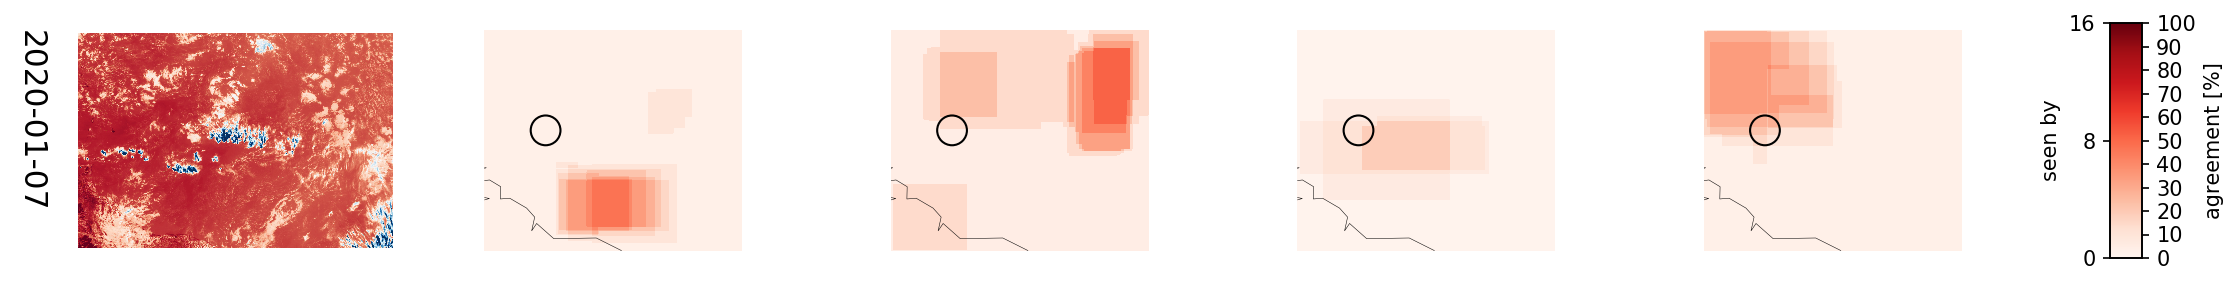

In [19]:
path_to_GOES13 = '../source_images/EUREC4A_IR_workflow/'
lons = np.linspace(-62,-44,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (IR)'
instrument = 'ABI'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_arr = np.zeros((len(np.unique(date_df.user_name)),
                         da_arr.shape[1],
                         da_arr.shape[2],
                         da_arr.shape[3]
                        ), dtype=bool)
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    for u, (user_name, user_df) in enumerate(date_df_sel.groupby('user_name')):
        class_ids = user_df.classification_id
        class_ids = np.unique(class_ids)
        user_arr = da_arr.sel({'classification_id':class_ids}).sum(axis=0).compute()
        user_arr = np.where(user_arr>0, True, False)
        date_arr[u, :,:,:] = user_arr

    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, date.strftime('GOES16_C13_%Y%m%d_1600'))
    if filename is None:
        filename = date.strftime('GOES16_C13_%Y%m%d_1700.jpeg')
    if filename is None: continue
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
    norm = Normalize(vmin = 0, vmax = len(np.unique(date_df_sel.user_name)), clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
        x, y = m(lon_grid, lat_grid)
        cs = m.contourf(x,y,np.sum(date_arr[:,:,:,p-1], axis=0), cmap='Reds', norm=norm)
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')

    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)

    # Show satellite image:
    img = plt.imread(path_to_GOES13+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='Reds', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('Users')
    
    cax2 = cax.twinx()
    user_ticks=np.linspace(0, len(np.unique(date_df_sel.user_name)),3)
    per_ticks=np.linspace(0,100,11).astype(int)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_label("seen by")
    cb.ax.yaxis.set_label_position("left")
    cax2.set_ylim(0,100)
    cax2.set_yticks(per_ticks)
    cax2.set_yticklabels(per_ticks)
    cax2.set_ylabel("agreement [%]")
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/IR_dailyaverage/EUREC4A_ManualClassifications_IRDailyAverage_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break

### Daily peak frequency based on workflow EUREC4A (IR)
!Very experimental!
Visualizing the time of most frequent classifications for every single pixel

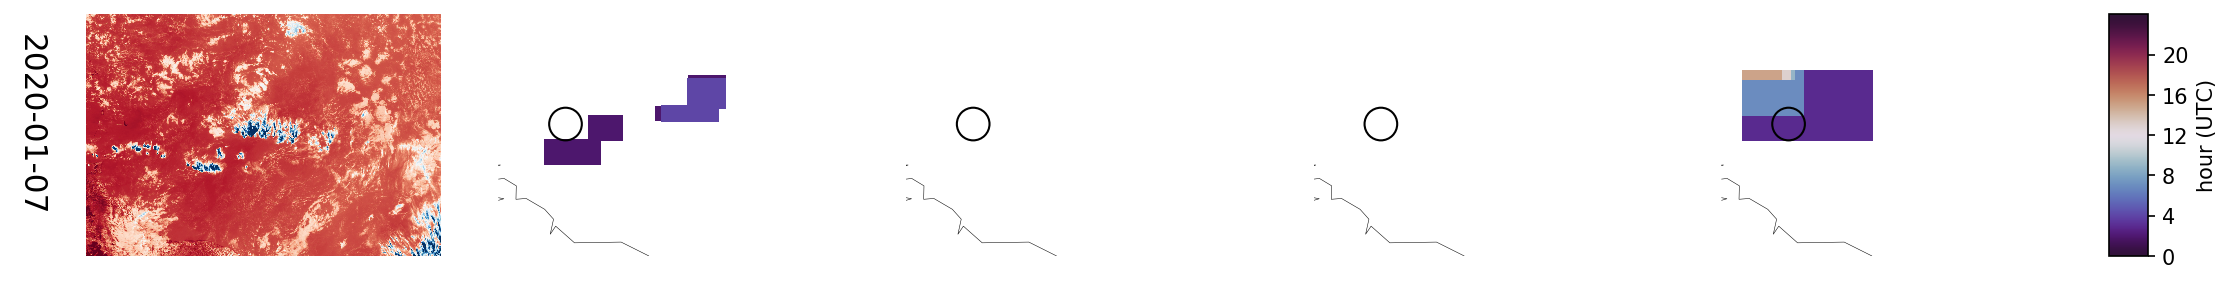

In [20]:
path_to_GOES13 = '../source_images/EUREC4A_IR_workflow/'
lons = np.linspace(-62,-44,2200)
lats = np.linspace(20,5,1500)

lat_grid, lon_grid = np.meshgrid(lats, lons)

workflow = 'EUREC4A (IR)'
instrument = 'ABI'

for d, (date, date_df) in enumerate(df_l1.groupby(df_l1['date'].dt.date)):
    date_df_sel = date_df.loc[np.logical_and(~date_df.already_seen.astype(bool),
                                             np.logical_and(date_df.workflow_name == workflow ,
                                                            date_df.instrument == instrument))]
    
    hour_arr = np.zeros((len(np.unique(date_df.date.dt.hour)),
                         da_arr.shape[1],
                         da_arr.shape[2],
                         da_arr.shape[3]
                        ), dtype=float)
    for h,(hours, hour_df) in enumerate(date_df_sel.groupby(date_df['date'].dt.hour)):
        for u, (user_name, user_df) in enumerate(hour_df.groupby('user_name')):
            class_ids = user_df.classification_id
            class_ids = np.unique(class_ids)
            user_arr = da_arr.sel({'classification_id':class_ids}).sum(axis=0).compute()
            user_arr = np.where(user_arr>0, True, False)
            hour_arr[h, :,:,:] += user_arr
        len_users = len(np.unique(hour_df.user_name))
        hour_arr[h, :,:,:] = hour_arr[h, :,:,:]/len_users
    hour_arr = np.where(hour_arr == 0 , np.nan, hour_arr)

    filenames = np.unique(date_df_sel.fn.values)
    filename = find_filename(filenames, date.strftime('GOES16_C13_%Y%m%d_1600'))
    if filename is None:
        filename = date.strftime('GOES16_C13_%Y%m%d_1700.jpeg')
    if filename is None: continue
    fig, ax = plt.subplots(1,6,figsize=(15,2), dpi=150, gridspec_kw={'width_ratios':[1,1,1,1,1,0.1]})
#     plt.suptitle(date,y=1.1)
    norm = Normalize(vmin = 0, vmax = 12, clip = False)
    for p in range(1,5):
        m = Basemap(ax=ax.flat[p], projection='merc',llcrnrlat=5,urcrnrlat=20,\
            llcrnrlon=-62,urcrnrlon=-40,lat_ts=20,resolution='c')
        m.drawcoastlines(linewidth=0.25)
#         ax.flat[p].set_title(pattern_dic_inv[p-1])
        x, y = m(lon_grid, lat_grid)
        argmax = np.argmax(hour_arr[:,:,:,p-1]+1, axis=0)
        peak_hour = np.where(argmax-1 == -1 ,np.nan,argmax) 
        cs = m.contourf(x,y,peak_hour, cmap='twilight_shifted', norm=norm)
        # HALO circle
        x,y=m(-57.717, 13.3)
        x2,y2 = m(-57.717,13.3+1.011) 
        circle1 = plt.Circle((x, y), y2-y, color='black',fill=False)
        ax.flat[p].add_patch(circle1)
        ax.flat[p].axis('off')
    
    ax.flat[0].annotate(date, (-0.2,0.2), rotation=-90, xycoords='axes fraction', fontsize=15)
    
    # Show satellite image:
    img = plt.imread(path_to_GOES13+filename)
    ax.flat[0].imshow(img)
    ax.flat[0].axis('off')
    
    cax = ax.flat[5]
    sm = plt.cm.ScalarMappable(cmap='twilight_shifted', norm=norm)
    sm._A = []
    cb = plt.colorbar(sm, cax=cax)
    cb.set_label('hour (UTC)')
    
    user_ticks=np.arange(0, 12, 2)
    cb.set_ticks(user_ticks.astype(int))
    cb.set_ticklabels([0,2,4,6,8,10,12,14,16,18,20,22][::2])
    
    plt.tight_layout()
    if savefig:
        plt.savefig('../figures/IR_peaktime/EUREC4A_ManualClassifications_IRPeak_{}.jpeg'.format(date.strftime('%Y%m%d')),
                dpi=150, bbox_inches='tight',pad=0)
        plt.close('all')
    else:
        plt.show()
        break